In [170]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import numpy as np
import os
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

## Retrieving and splitting data 

In [162]:
df = pd.read_csv('training_dataset.csv')
X = df.loc[:, 'rms_mean':]
y = df['classID']

#list of folds using indices of each file
folds = [(df.loc[df['fold'] != i].index, df.loc[df['fold'] == i].index) for i in range(1, 11)]

In [161]:
df.columns

Index(['slice_file_name', 'classID', 'fold', 'rms_mean', 'rms_std', 'zcr_mean',
       'zcr_std', 'spec_cent_mean', 'spec_cent_std', 'tempo', 's_flux_mean',
       's_flux_std', 's_flux_max', 'mfcc_mean', 'mfcc_std', 'mfcc_max',
       'mfcc_min', 'mfcc_25%', 'mfcc_50%', 'mfcc_75%', 'mfcc_delta_mean',
       'mfcc_delta_std', 'mfcc_delta_max', 'mfcc_delta_min', 'mfcc_delta_25%',
       'mfcc_delta_50%', 'mfcc_delta_75%', 'mfcc_delta2_mean',
       'mfcc_delta2_std', 'mfcc_delta2_max', 'mfcc_delta2_min',
       'mfcc_delta2_25%', 'mfcc_delta2_50%', 'mfcc_delta2_75%'],
      dtype='object')

In [173]:
class_dict = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

## Logistic Regression

In [167]:
preprocessor = ColumnTransformer(transformers = [
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', LogisticRegression())
    ]
)

param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [1e-3, 1e-1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga']
}

logreg = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

logreg.fit(X, y)
print(f"Best: {logreg.best_score_} using {logreg.best_params_}")

Best: 0.6611187892552222 using {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


## XGBoost

In [168]:
preprocessor = ColumnTransformer(transformers = [
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', XGBClassifier())
    ]
)

param_grid = {
    'model__eta': [0.01, 0.1, 0.3],
    'model__max_depth': [2, 6, 10],
    'model__n_estimators': [100, 300, 500]
}

gs = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

gs.fit(X, y)
print(f"Best: {gs.best_score_} using {gs.best_params_}")

Best: 0.6864914171160094 using {'model__eta': 0.3, 'model__max_depth': 6, 'model__n_estimators': 500}


### Feature Importances with XGBoost

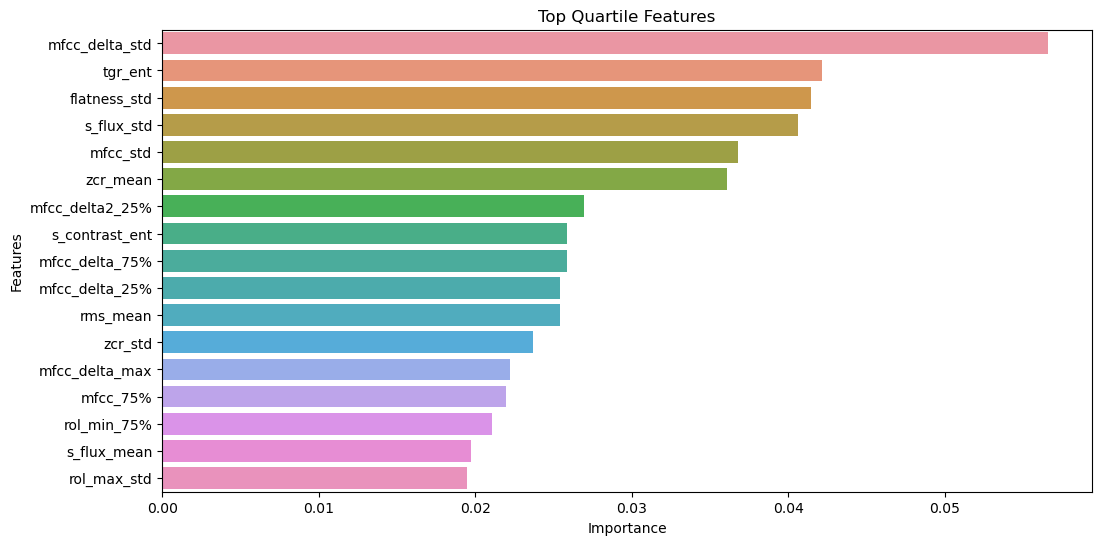

In [305]:
cv_results = pd.DataFrame(gs.cv_results_)
best_estimator = gs.best_estimator_
feature_importances = best_estimator['model'].feature_importances_

#extract tuples (feature_names, feature_importances)
names_importances = sorted(list(zip(X.columns, feature_importances)), key = lambda x: x[1], reverse = True)

#3rd quantile of feature importances
q3 = np.quantile(feature_importances, 0.75)

top_q_features = [(name, importance) for name, importance in names_importances if importance >= q3]

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(y = [feature[0] for feature in top_q_features], x = [feature[1] for feature in top_q_features],
            orient = 'h', ax = ax).set(
            ylabel = 'Features',
            xlabel = 'Importance',
            title = 'Top Quartile Features');

### Performance per learning rate

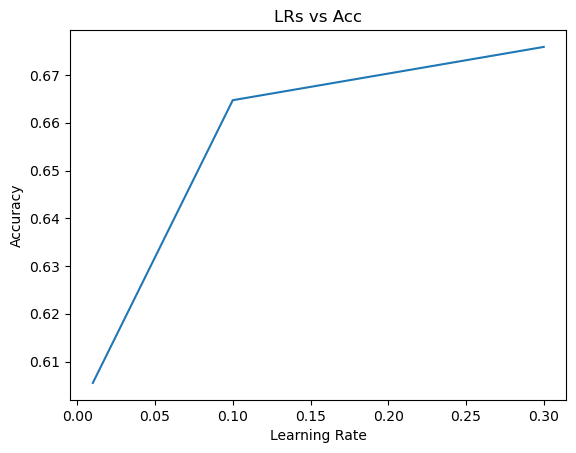

In [309]:
scores = gs.cv_results_['mean_test_score']
learning_rates = gs.cv_results_['param_model__eta']

sc_lr = {}
for sc, lr in zip(scores, learning_rates):
    if lr not in sc_lr:
        sc_lr[lr] = [[sc], sc]
    else:
        sc_lr[lr][0].append(sc)
        sc_lr[lr][1] = np.mean(sc_lr[lr][0])

sns.lineplot(x = sc_lr.keys(), y = [mean[1] for mean in sc_lr.values()]).set(
xlabel='Learning Rate', ylabel='Accuracy', title='LRs vs Acc');

### Performance per max depth of trees

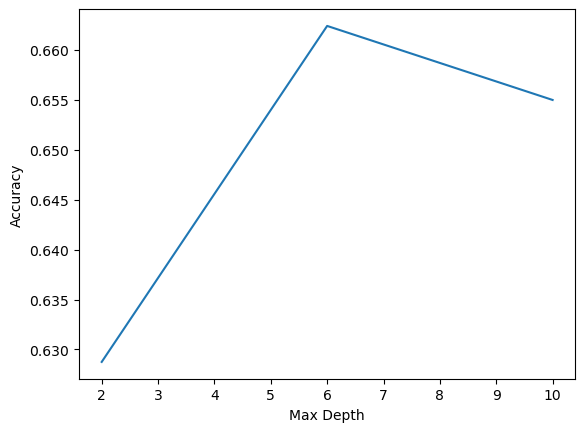

In [310]:
max_depth_list = gs.cv_results_['param_model__max_depth']

max_depth = {}
for sc, md in zip(scores, max_depth_list):
    if md not in max_depth:
        max_depth[md] = [[sc], sc]
    else:
        max_depth[md][0].append(sc)
        max_depth[md][1] = np.mean(max_depth[md][0])

sns.lineplot(x = max_depth.keys(), y = [mean[1] for mean in max_depth.values()]).set(
xlabel='Max Depth', ylabel = 'Accuracy');

### Performance per number of estimators

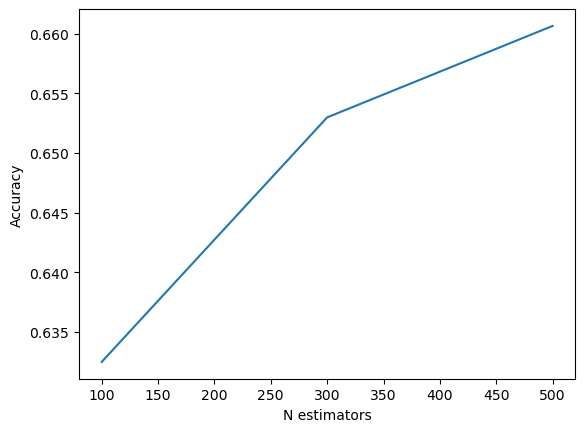

In [195]:
n_estimators_list = gs.cv_results_['param_model__n_estimators']

n_estimators = {}
for sc, ne in zip(scores, n_estimators_list):
    if ne not in n_estimators:
        n_estimators[ne] = [[sc], sc]
    else:
        n_estimators[ne][0].append(sc)
        n_estimators[ne][1] = np.mean(n_estimators[ne][0])

sns.lineplot(x = n_estimators.keys(), y = [mean[1] for mean in n_estimators.values()]).set(
xlabel='N estimators', ylabel = 'Accuracy');

## CNN

In [3]:
#Extract audio paths of all files
def get_audio_files(path:str):
    counter = 0
    files = []
    
    for file in os.listdir(path):
        if os.path.isdir(f"{path}/{file}"):
            files.extend(get_audio_files(f"{path}/{file}"))
        else:
            title, ext = os.path.splitext(f"{path}/{file}")
            if ext == '.wav':
                files.append(title + ext)
                counter += 1
    return files
    
        

audio_paths = get_audio_files('data')

In [5]:
#Extracts mel-spectrograms of all audio files
def get_mel_sgrams(files:list):
    mel_sgrams = {}
    for file in files:
        samples, sample_rate = librosa.load(file)
        sgram = librosa.stft(samples)
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        mel_sgrams[file] = mel_sgram
    return mel_sgrams

mel_sgrams = get_mel_sgrams(audio_paths)

In [7]:
#gets max number of columns in the spectrogram
max_length = 0

for i, sgram in enumerate(mel_sgrams.values()):
    if sgram.shape[1] > max_length:
        max_length = sgram.shape[1]
print(f"Max length of mel-spectrograms: {max_length}")

Max length of mel-spectrograms: 174


### Zero-padded spectrograms

Audio files have different durations, therefore the dimensions of the spectrograms are gonna be different. They need to be zero-padded, so the dimensions match and can be used in the CNN

In [8]:
def zero_pad_spectrogram(spectrogram, max_length):

    current_length = spectrogram.shape[1]
    padding = max_length - current_length

  # Creates a zero padding array
    padding_array = np.zeros((spectrogram.shape[0], padding))

  # Stacks the spectrogram and padding array horizontally
    padded_spectrogram = np.hstack((spectrogram, padding_array))

    return padded_spectrogram


Structure of zero padded dictionary:

    N-fold

    |

    v

[Train], [Validation]

    |

    V

[X_train, X_val], [y_train, y_val]

In [91]:

zero_padded = {i: [[[], []], [[], []]] for i in range(1, 11)}

for path, sgram in mel_sgrams.items():
    zero_pad = zero_pad_spectrogram(sgram, max_length)
    file_name = path.split('/')[-1]
    target = df.loc[df['slice_file_name'] == file_name, 'classID'].values[0]
    fold = df.loc[df['slice_file_name'] == file_name, 'fold'].values[0]
    zero_padded[fold][1][0].append(zero_pad)
    zero_padded[fold][1][1].append(target)
    for i in range(1, 11):
        if i != fold:
            zero_padded[i][0][0].append(zero_pad)
            zero_padded[i][0][1].append(target)
    

In [93]:
#One hot encode the targets
ohe = OneHotEncoder(sparse_output = False)
for fold in zero_padded.values():
    fold[0][1] = ohe.fit_transform(np.array(fold[0][1]).reshape(-1, 1))
    fold[1][1] = ohe.fit_transform(np.array(fold[1][1]).reshape(-1, 1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Convolutional layers with ReLU activation and MaxPooling
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten for dense layers
    x = Flatten()(x)

    # Dense layers with ReLU activation and dropout for regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer with softmax activation for multi-class classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model

# Define model input shape based on spectrograms
input_shape = (128, 174, 1) 

# Number of targets
num_classes = 10

# Build the CNN model
model = build_cnn_model(input_shape, num_classes)

loss = []
accuracy = []
# Train model cross-validating pre-determined folds
for fold in range(1, 11):

    x_train = np.array(zero_padded[fold][0][0])
    y_train = zero_padded[fold][0][1]
    x_test = np.array(zero_padded[fold][1][0])
    y_test = zero_padded[fold][1][1]
    model.fit(x_train, y_train, epochs=10)

    # Evaluate the fold
    test_loss, test_acc = model.evaluate(x_test, y_test)
    
    loss.append(test_loss)
    accuracy.append(test_acc)
    
    print('Test accuracy:', test_acc)

Epoch 1/10


2024-02-16 14:05:54.870670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 24s 93ms/step - loss: 318.8925 - accuracy: 0.1311
Epoch 2/10
246/246 [==============================] - 22s 91ms/step - loss: 130.1142 - accuracy: 0.1447
Epoch 3/10
246/246 [==============================] - 23s 93ms/step - loss: 70.3642 - accuracy: 0.1591
Epoch 4/10
246/246 [==============================] - 22s 90ms/step - loss: 41.6290 - accuracy: 0.1640
Epoch 5/10
246/246 [==============================] - 23s 92ms/step - loss: 87.4591 - accuracy: 0.1696
Epoch 6/10
246/246 [==============================] - 22s 91ms/step - loss: 172.2337 - accuracy: 0.1508
Epoch 7/10
246/246 [==============================] - 22s 91ms/step - loss: 165.7411 - accuracy: 0.1937
Epoch 8/10
246/246 [==============================] - 22s 90ms/step - loss: 138.7992 - accuracy: 0.2084
Epoch 9/10
246/246 [==============================] - 22s 88ms/step - loss: 159.2572 - accuracy: 0.2172
Epoch 10/10
 3/28 [==>...........................] - ETA: 0s - loss: 131.1666 

2024-02-16 14:09:39.572264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 37ms/step - loss: 139.7099 - accuracy: 0.2119
Test accuracy: 0.21191295981407166
Epoch 1/10
246/246 [==============================] - 23s 92ms/step - loss: 110.5202 - accuracy: 0.2570
Epoch 2/10
246/246 [==============================] - 22s 90ms/step - loss: 119.0320 - accuracy: 0.2490
Epoch 3/10
246/246 [==============================] - 22s 90ms/step - loss: 117.4499 - accuracy: 0.2670
Epoch 4/10
246/246 [==============================] - 22s 90ms/step - loss: 110.7740 - accuracy: 0.2732
Epoch 5/10
246/246 [==============================] - 22s 90ms/step - loss: 127.1743 - accuracy: 0.2764
Epoch 6/10
246/246 [==============================] - 22s 91ms/step - loss: 132.1470 - accuracy: 0.2803
Epoch 7/10
246/246 [==============================] - 23s 92ms/step - loss: 177.8856 - accuracy: 0.2691
Epoch 8/10
246/246 [==============================] - 23s 93ms/step - loss: 172.9729 - accuracy: 0.2911
Epoch 9/10
246/246 [=======================

26/26 [==============================] - 1s 38ms/step - loss: 1550.3749 - accuracy: 0.5409
Test accuracy: 0.540942907333374


In [293]:
print('Accuracies per validation:', accuracy, '\n')
print('Mean accuracy:', np.array(accuracy).mean(), '\n')
print('Loss per validation:', loss, '\n')
print('Mean loss:', np.array(loss).mean(), '\n')

Accuracies per validation: [0.18098512291908264, 0.2015765756368637, 0.2875675857067108, 0.41515153646469116, 0.5256410241127014, 0.4617254137992859, 0.3329355716705322, 0.5235732197761536, 0.4522058963775635, 0.49581843614578247] 

Mean accuracy: 0.38771803826093676 

Loss per validation: [2.9479503631591797, 9.189982414245605, 38.66249084472656, 288.1620788574219, 2509.887451171875, 22392.0390625, 296829.8125, 490513.90625, 1230928.5, 2782438.75] 

Mean loss: 482595.18577661517 



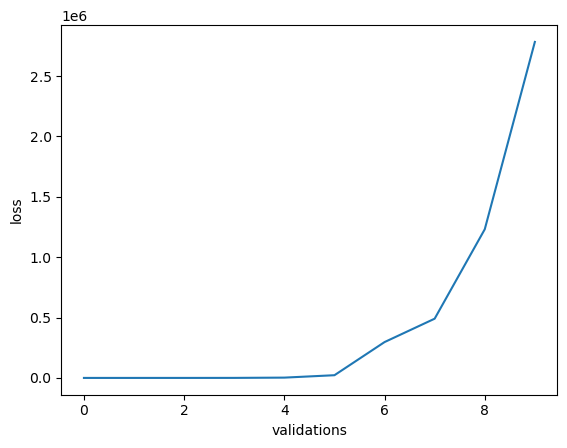

In [299]:
sns.lineplot(x = range(len(loss)), y = loss).set(xlabel = 'validations', ylabel = 'loss');

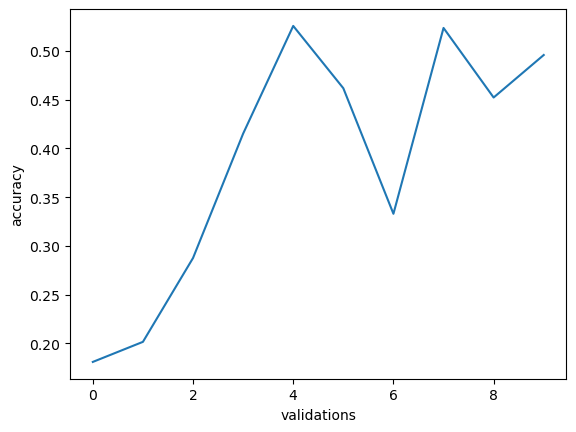

In [301]:
sns.lineplot(x = range(len(accuracy)), y = accuracy).set(xlabel = 'validations', ylabel = 'accuracy');